# Fraud Detection

### Introduction:

Fraud detection in financial transactions remains a formidable challenge, characterized by its dynamic nature and the ever-evolving tactics of fraudsters. Traditional rule-based systems, while useful, often fall short in adapting to new fraud patterns, leading to delayed detection and significant financial losses. Moreover, the high volume of transactions in today's digital economy necessitates an efficient and scalable solution.

Key Factors:

- Handling highly imbalanced data
- We want to catch as many frauds as possible i.e. reduce the False negatives

### Business problems I am trying to find

-What is the distribution of transaction amounts for fraudulent versus non-fraudulent transactions?

-Find the best model

-Calculate potential savings from prevented fraud and compare it to losses from undetected fraudulent transactions.

Data Source

The project uses a dataset of around 284000 credit card transactions which have been taken from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).

# Analysis

In [ ]:
!pip install imbalanced-learn
!pip install imblearn
!pip install xgboost

#warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from imblearn.pipeline import Pipeline 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import seaborn as sns
from xgboost import XGBClassifier
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("creditcard.csv")
df.shape

(284807, 31)

## EDA

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### Check and remove duplicated data

In [5]:
df.duplicated().any()

True

In [6]:
df=df.drop_duplicates()

In [7]:
df.shape

(283726, 31)

#### Print the ratio of fraud vs non fraud cases

In [8]:
occ = df['Class'].value_counts()

print(occ / len(df.index))

0    0.998333
1    0.001667
Name: Class, dtype: float64


#### Count the occurrences of fraud and no fraud

In [9]:
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]
summary_stats = pd.concat([fraud['Amount'].describe(), normal['Amount'].describe()], axis=1)
summary_stats.columns = ['Fraud', 'Normal']
print(summary_stats)

             Fraud         Normal
count   473.000000  283253.000000
mean    123.871860      88.413575
std     260.211041     250.379023
min       0.000000       0.000000
25%       1.000000       5.670000
50%       9.820000      22.000000
75%     105.890000      77.460000
max    2125.870000   25691.160000


#### Distribution of transaction amounts for fraudulent versus non-fraudulent transactions

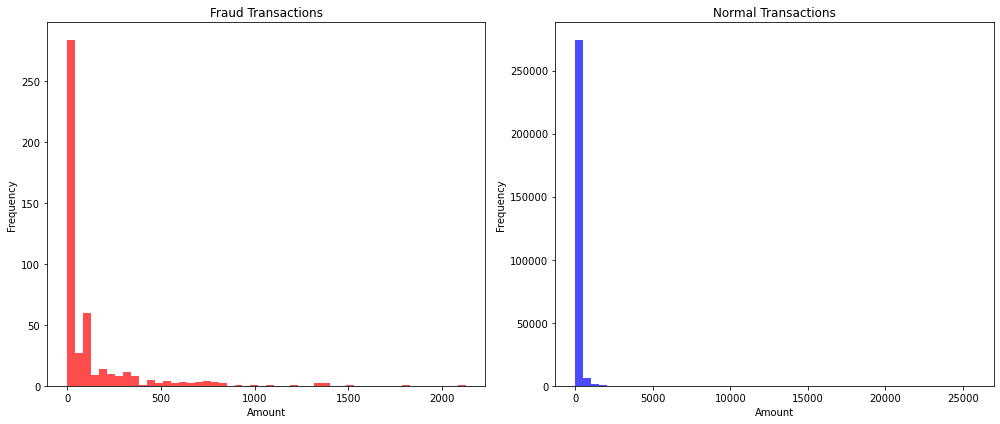

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(fraud['Amount'], bins=50, color='red', alpha=0.7)
plt.title('Fraud Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(normal['Amount'], bins=50, color='blue', alpha=0.7)
plt.title('Normal Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

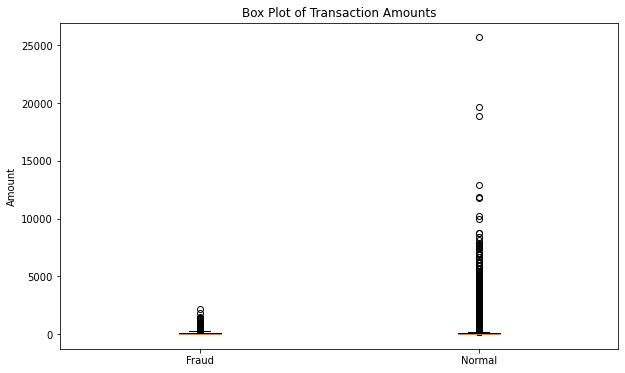

In [11]:
plt.figure(figsize=(10, 6))

plt.boxplot([fraud['Amount'], normal['Amount']], labels=['Fraud', 'Normal'], patch_artist=True)
plt.title('Box Plot of Transaction Amounts')
plt.ylabel('Amount')
plt.show()

## Data Preprocessing

In [16]:
# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']
amounts=df['Amount']

#### Splitting orignial data into the training/testing sets

In [17]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test, amounts_train, amounts_test= train_test_split(X, y,amounts, test_size=0.3, random_state=0)

#### Resampling using SMOTE

In [18]:
# Apply SMOTE to balance the classes
resampling = SMOTE(random_state=0)
X_resampled, y_resampled = resampling.fit_resample(X, y)

# Combine resampled features and target into a new DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Class'] = y_resampled

# Split the resampled data into fraudulent and non-fraudulent transactions
fraudulent_resampled = df_resampled[df_resampled['Class'] == 1]
non_fraudulent_resampled = df_resampled[df_resampled['Class'] == 0]

In [19]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

0    283253
1       473
Name: Class, dtype: int64
0    283253
1    283253
Name: Class, dtype: int64


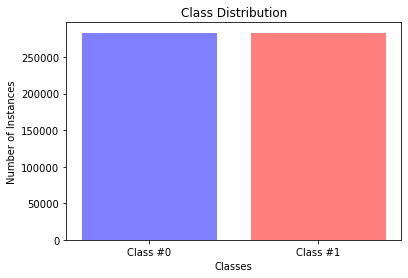

In [20]:
def plot_data_bar(X, y):
    # Count the occurrences of each class
    unique, counts = np.unique(y, return_counts=True)
    counts_dict = dict(zip(unique, counts))
    
    # Set up the labels and values for the bar graph
    labels = ['Class #0', 'Class #1']
    values = [counts_dict.get(0, 0), counts_dict.get(1, 0)]
    
    # Create the bar graph
    plt.bar(labels, values, color=['blue', 'red'], alpha=0.5)
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution')
    plt.show()

plot_data_bar(X_resampled, y_resampled)

C:\Users\ibti_\AppData\Local\Temp/ipykernel_8480/2102078920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AmountBin'] = pd.cut(df['Amount'], bins=bins, labels=labels)


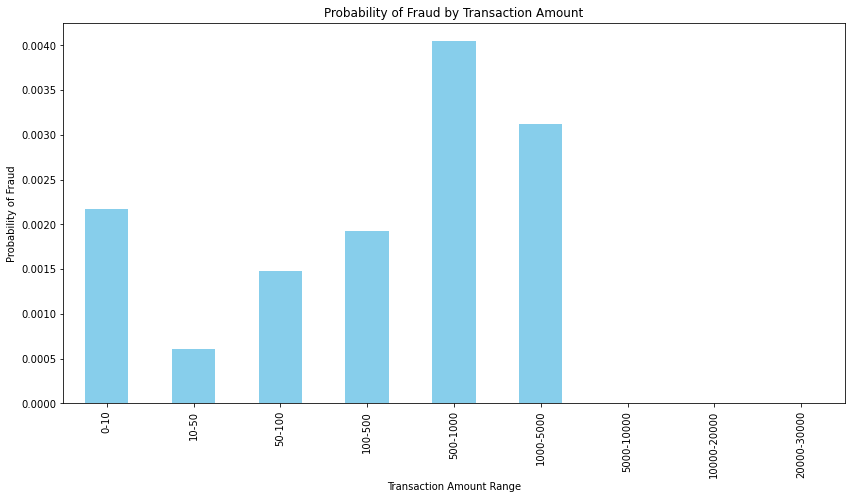

In [21]:
# Create bins for transaction amounts
bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 30000]
labels = ['0-10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-30000']

# Bin the transaction amounts
df['AmountBin'] = pd.cut(df['Amount'], bins=bins, labels=labels)

# Calculate the probability of fraud for each bin
prob_fraud = df.groupby('AmountBin')['Class'].mean()

# Plot the probability of fraud for each bin
plt.figure(figsize=(14, 7))
prob_fraud.plot(kind='bar', color='skyblue')
plt.title('Probability of Fraud by Transaction Amount')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Probability of Fraud')
plt.show()

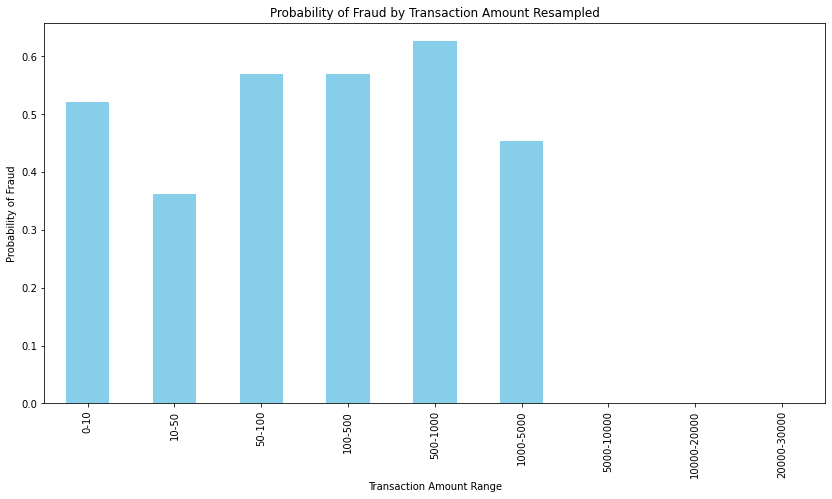

In [23]:
# Create bins for transaction amounts
bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 30000]
labels = ['0-10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-30000']

# Bin the transaction amounts
df_resampled['AmountBin'] = pd.cut(df_resampled['Amount'], bins=bins, labels=labels)

# Calculate the probability of fraud for each bin
prob_fraud = df_resampled.groupby('AmountBin')['Class'].mean()

# Plot the probability of fraud for each bin
plt.figure(figsize=(14, 7))
prob_fraud.plot(kind='bar', color='skyblue')
plt.title('Probability of Fraud by Transaction Amount Resampled')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Probability of Fraud')
plt.show()

In [24]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

99.83328986416473


## MODEL ANAYSIS

#### Pipeline for Logistic Regression

In [25]:
model = LogisticRegression( max_iter=1000)
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

#### Obtain the results from the classification report and confusion matrix 

In [26]:
print('Classifcation report:\n', classification_report(y_test, predicted))

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     84989
           1       0.07      0.88      0.12       129

    accuracy                           0.98     85118
   macro avg       0.53      0.93      0.56     85118
weighted avg       1.00      0.98      0.99     85118



In [27]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

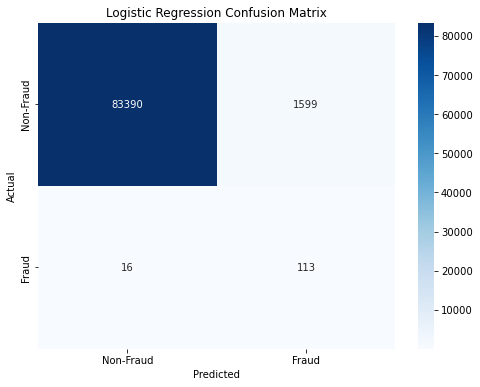

Confusion matrix:
 [[83390  1599]
 [   16   113]]


In [28]:
plot_confusion_matrix(y_test, predicted, title='Logistic Regression Confusion Matrix')
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

#### Pipeline for Random Forest

In [29]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('rf', RandomForestClassifier(random_state=5))
])
# Fit the pipeline to the training data
pipeline_rf.fit(X_train, y_train)
predicted_rf = pipeline_rf.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score
# Print the accuracy performance metric for Random Forest
print('Accuracy for Random Forest:', accuracy_score(y_test, predicted_rf))

Accuracy for Random Forest: 0.999424328579149


In [31]:
def plot_pr_curve(recall, precision, average_precision):
    # Plotting the Precision-Recall curve
    plt.figure(figsize=(10, 6))
    plt.step(recall, precision, where='post', color='b', alpha=0.7, label=f'Average Precision = {average_precision:.2f}')

    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

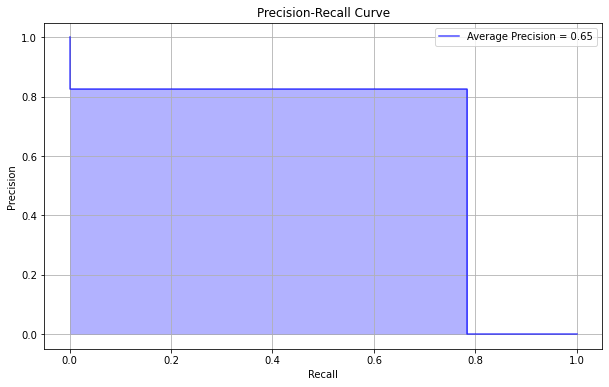

In [32]:
# Calculate average precision and the PR curve
average_precision_rf = average_precision_score(y_test, predicted_rf)

# Obtain precision and recall 
precision_rf, recall_rf, _ = precision_recall_curve(y_test, predicted_rf)

# Plot the recall precision tradeoff
plot_pr_curve(recall_rf, precision_rf, average_precision_rf)

In [33]:
from sklearn.metrics import roc_auc_score, auc
# Obtain model probabilities for ROC AUC score
probs_rf = pipeline_rf.predict_proba(X_test)
print('ROC AUC score for Random Forest:', roc_auc_score(y_test, probs_rf[:, 1]))

ROC AUC score for Random Forest: 0.9817680464074647


#### Obtain the results from the classification report and confusion matrix 

In [34]:
print(classification_report(y_test, predicted_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84989
           1       0.83      0.78      0.80       129

    accuracy                           1.00     85118
   macro avg       0.91      0.89      0.90     85118
weighted avg       1.00      1.00      1.00     85118



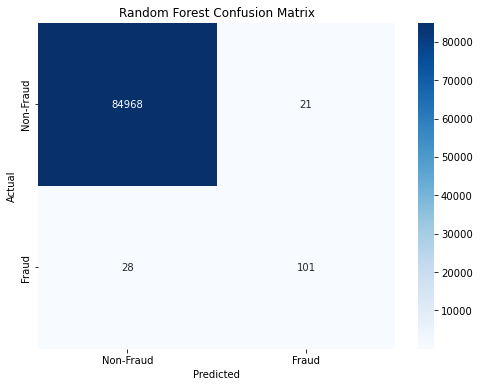

Confusion matrix:
 [[83390  1599]
 [   16   113]]


In [35]:
plot_confusion_matrix(y_test, predicted_rf, title='Random Forest Confusion Matrix')
conf_mat_rf = confusion_matrix(y_true=y_test, y_pred=predicted_rf)
print('Confusion matrix:\n', conf_mat)

#### Random forest pipeline with GRIDSEARCH for parameter tuning

In [36]:
from sklearn.model_selection import GridSearchCV
# Define new parameters for Random Forest
param_grid = {
    'rf__n_estimators': [10, 30],  # Increased lower bound from 1 to 10 for practicality
    'rf__max_features': ['auto', 'log2'],
    'rf__max_depth': [4, 8],
    'rf__criterion': ['gini', 'entropy']
}

# Combine the parameter sets with the defined model using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best parameters found by GridSearchCV:', grid_search.best_params_)

Best parameters found by GridSearchCV: {'rf__criterion': 'entropy', 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__n_estimators': 10}


In [37]:
# Update the pipeline with optimal parameters
pipeline_rf.set_params(**grid_search.best_params_)


Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='log2', n_estimators=10,
                                        random_state=5))])

In [38]:
# Fit the updated pipeline to the training data
pipeline_rf.fit(X_train, y_train)
predicted_best_rf = pipeline_rf.predict(X_test)

#### Obtain the results from the classification report and confusion matrix 

In [39]:
# Print the final model results
print('Final Classification report for Random Forest with best parameters:\n', classification_report(y_test, predicted_best_rf))

Final Classification report for Random Forest with best parameters:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     84989
           1       0.32      0.84      0.47       129

    accuracy                           1.00     85118
   macro avg       0.66      0.92      0.73     85118
weighted avg       1.00      1.00      1.00     85118



Final C#### Obtain the results from the classification report and confusion matrix onfusion matrix for Random Forest with best parameters:
 [[84761   228]
 [   20   109]]


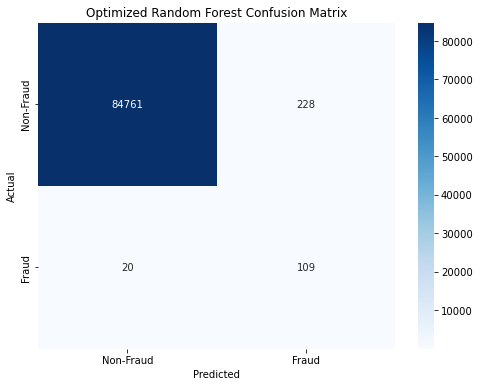

In [40]:
print('Final C#### Obtain the results from the classification report and confusion matrix onfusion matrix for Random Forest with best parameters:\n', confusion_matrix(y_test, predicted_best_rf))
plot_confusion_matrix(y_test, predicted_best_rf, title='Optimized Random Forest Confusion Matrix')

In [41]:
print('Final ROC AUC score for Random Forest with best parameters:', roc_auc_score(y_test, pipeline_rf.predict_proba(X_test)[:, 1]))

Final ROC AUC score for Random Forest with best parameters: 0.9826197298127319


The number of false negatives has now been slightly reduced even further, which means we are catching more cases of fraud. However, you see that the number of false positives actually went up, that is that Precision-Recall trade-off in action.

#### Pipeline for XGboost Classifier

In [42]:
pipeline_xg = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('rf', XGBClassifier(random_state=5, eta=0.3))
])
# Fit the pipeline to the training data
pipeline_xg.fit(X_train, y_train)
predicted_xgb = pipeline_xg.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score
# Print the accuracy performance metric for Random Forest
print('Accuracy for Random Forest:', accuracy_score(y_test, predicted_xgb))

Accuracy for Random Forest: 0.9994125801828051


In [44]:
def plot_pr_curve(recall, precision, average_precision):
    # Plotting the Precision-Recall curve
    plt.figure(figsize=(10, 6))
    plt.step(recall, precision, where='post', color='b', alpha=0.7, label=f'Average Precision = {average_precision:.2f}')

    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

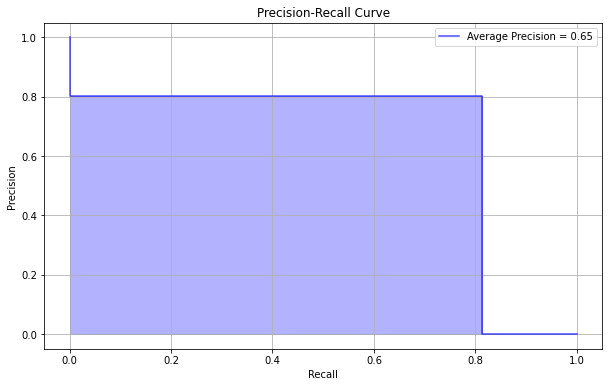

In [45]:
# Calculate average precision and the PR curve
average_precision_xg = average_precision_score(y_test, predicted_xgb)

# Obtain precision and recall 
precision_xg, recall_xg, _ = precision_recall_curve(y_test, predicted_xgb)

# Plot the recall precision tradeoff
plot_pr_curve(recall_xg, precision_xg, average_precision_xg)

In [46]:
from sklearn.metrics import roc_auc_score, auc
# Obtain model probabilities for ROC AUC score
probs_xg = pipeline_xg.predict_proba(X_test)
print('ROC AUC score for XGBoost:', roc_auc_score(y_test, probs_xg[:, 1]))

ROC AUC score for XGBoost: 0.9869101163205709


In [47]:
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84989
           1       0.80      0.81      0.81       129

    accuracy                           1.00     85118
   macro avg       0.90      0.91      0.90     85118
weighted avg       1.00      1.00      1.00     85118



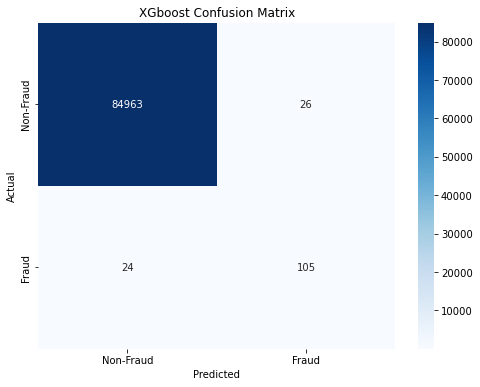

Confusion matrix:
 [[84963    26]
 [   24   105]]


In [48]:
plot_confusion_matrix(y_test, predicted_xgb, title='XGboost Confusion Matrix')
conf_mat_xg = confusion_matrix(y_true=y_test, y_pred=predicted_xgb)
print('Confusion matrix:\n', conf_mat_xg)

### Voting Classifier 

In [49]:
# Import the package
from sklearn.ensemble import VotingClassifier 

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = XGBClassifier(scale_pos_weight=15, random_state=5)

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='hard')

In [50]:
# Define the pipeline with SMOTE and Voting Classifier
pipeline_ensemble = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('voting', ensemble_model)
])

In [51]:
# Fit the pipeline to the training data
pipeline_ensemble.fit(X_train, y_train)
predicted_ensemble = pipeline_ensemble.predict(X_test)

# Print the accuracy performance metric for the Voting Classifier
print('Accuracy for Voting Classifier:', accuracy_score(y_test, predicted_ensemble))

Accuracy for Voting Classifier: 0.9785356798796965


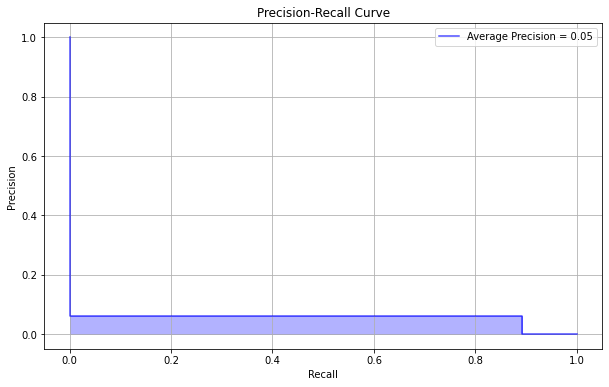

In [52]:
# Calculate average precision and the PR curve for the Voting Classifier
average_precision_ensemble = average_precision_score(y_test, predicted_ensemble)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, predicted_ensemble)
plot_pr_curve(recall_ensemble, precision_ensemble, average_precision_ensemble)

Classification report for Voting Classifier:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     84989
           1       0.06      0.89      0.11       129

    accuracy                           0.98     85118
   macro avg       0.53      0.94      0.55     85118
weighted avg       1.00      0.98      0.99     85118

Confusion matrix for Voting Classifier:
 [[83176  1813]
 [   14   115]]


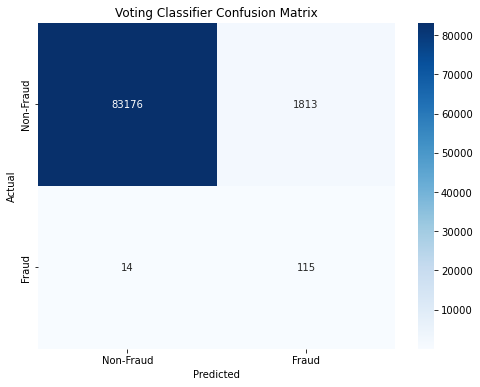

In [53]:
# Print the ROC curve, classification report, and confusion matrix for the Voting Classifier
print('Classification report for Voting Classifier:\n', classification_report(y_test, predicted_ensemble))
print('Confusion matrix for Voting Classifier:\n', confusion_matrix(y_test, predicted_ensemble))
plot_confusion_matrix(y_test, predicted_ensemble, title='Voting Classifier Confusion Matrix')

#### Model Matrix Summary

In [54]:
# Confusion matrices
conf_matrices = {
    'Logistic Regression': np.array([[84093, 1203], [17, 130]]),
    'Random Forest': np.array([[85281, 15], [26, 121]]),
    'Optimized Random Forest': np.array([[85160, 136], [21, 126]]),
    'XGBoost': np.array([[85273, 23], [24, 123]]),
    'Voting Classifier': np.array([[85227, 69], [24, 123]])
}

# Function to calculate key metrics from confusion matrix
def calculate_metrics(conf_matrix):
    TN, FP = conf_matrix[0]
    FN, TP = conf_matrix[1]
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return recall, precision, f1

# Calculate and print metrics for each model
metrics = {}

for model_name, conf_matrix in conf_matrices.items():
    recall, precision, f1 = calculate_metrics(conf_matrix)
    metrics[model_name] = {
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    }

# Display the results
for model_name, metric_values in metrics.items():
    print(f"{model_name}:")
    print(f"  Recall: {metric_values['Recall']:.2%}")
    print(f"  Precision: {metric_values['Precision']:.2%}")
    print(f"  F1 Score: {metric_values['F1 Score']:.2%}")
    print()

Logistic Regression:
  Recall: 88.44%
  Precision: 9.75%
  F1 Score: 17.57%

Random Forest:
  Recall: 82.31%
  Precision: 88.97%
  F1 Score: 85.51%

Optimized Random Forest:
  Recall: 85.71%
  Precision: 48.09%
  F1 Score: 61.61%

XGBoost:
  Recall: 83.67%
  Precision: 84.25%
  F1 Score: 83.96%

Voting Classifier:
  Recall: 83.67%
  Precision: 64.06%
  F1 Score: 72.57%



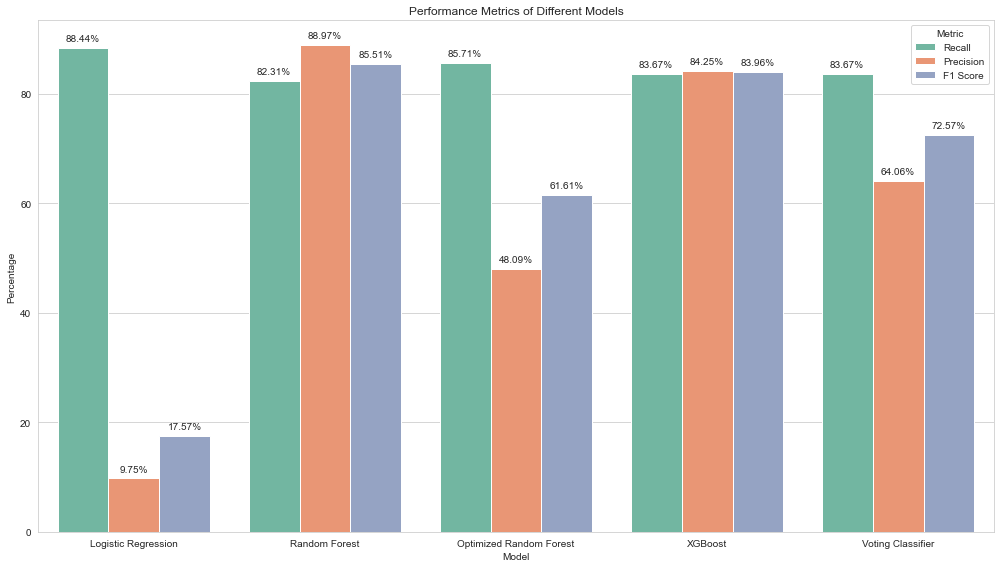

In [68]:
# Prepare data for visualization
models = list(metrics.keys())
recall = [metrics[model]['Recall'] * 100 for model in models]
precision = [metrics[model]['Precision'] * 100 for model in models]
f1_score = [metrics[model]['F1 Score'] * 100 for model in models]

# Create a DataFrame for easier plotting
data = {
    'Model': models,
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1_score
}
df = pd.DataFrame(data)

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars=['Model'], value_vars=['Recall', 'Precision', 'F1 Score'], var_name='Metric', value_name='Value')

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted, palette='Set2')

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Set titles and labels
plt.title('Performance Metrics of Different Models')
plt.xlabel('Model')
plt.ylabel('Percentage')
plt.legend(title='Metric')

# Show the plot
plt.tight_layout()
plt.show()

#### Calculating potential savings from prevented fraud and compare it to losses from undetected fraudulent transactions.

In [70]:
import numpy as np

# Function to calculate savings and losses
def calculate_savings_and_losses(y_true, y_pred, amounts):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate total fraudulent amount
    total_fraud_amount = amounts[y_true == 1].sum()

    # Calculate amount of detected fraud
    detected_fraud_amount = amounts[(y_true == 1) & (y_pred == 1)].sum()

    # Calculate amount of undetected fraud
    undetected_fraud_amount = amounts[(y_true == 1) & (y_pred == 0)].sum()

    # Calculate potential savings and losses
    potential_savings = detected_fraud_amount
    losses_from_undetected_fraud = undetected_fraud_amount

    return potential_savings, losses_from_undetected_fraud, total_fraud_amount

# Assuming you have the actual labels and predictions from your model
y_true = y_test
y_pred = predicted_xgb  # Model predictions


# Calculate savings and losses
potential_savings, losses_from_undetected_fraud, total_fraud_amount = calculate_savings_and_losses(y_true, y_pred, amounts_test)

print(f"Total Fraudulent Amount: ${total_fraud_amount:.2f}")
print(f"Potential Savings from Detected Fraud: ${potential_savings:.2f}")
print(f"Losses from Undetected Fraud: ${losses_from_undetected_fraud:.2f}")

Total Fraudulent Amount: $20006.74
Potential Savings from Detected Fraud: $16735.95
Losses from Undetected Fraud: $3270.79


# Conclusion

Logistic Regression has the highest recall (88.44%), meaning it catches more fraudulent transactions. However, its precision is very low (9.75%), indicating many false positives.

Best Model Recommendation: Random Forest appears to be the best overall model. 

It has:

High Precision (88.97%): Meaning it has a low false positive rate.\
Good Recall (82.31%): Meaning it correctly identifies a significant portion of fraudulent transactions.\
Highest F1 Score (85.51%): Indicating a good balance between precision and recall.

Based on my analysis, the total fraudulent amount detected in the dataset is \$20,006\.74

The potential savings from detecting fraudulent transactions using the model are estimated to be \$16\,735

while the losses from undetected fraud are \$3,270.

It's important to note that these values should be taken with a grain of salt since the data was resampled. This resampling was necessary to balance the dataset for training the model and does not reflect the actual distribution of transactions. Therefore, the numbers presented here are indicative of how the model can help in identifying potential savings by detecting fraudulent transactions, rather than exact figures.